In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import style
style.use('ggplot')

import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.kernel_ridge import KernelRidge 
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import pandas as pd

import eli5
from eli5.sklearn import PermutationImportance

import pickle

from IPython.display import display, Image

from pdpbox import pdp, info_plots

import shap

#my modules
from data_prep import *
from mltools.model_selection import *
from mltools.visualisation import *



random_state = 250


c:\users\brend\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\brend\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
img_path = r'images'

In this notebook, we want to explore which factors are the best predictors of heart disease, and we also want to explore the relationships between the features. A quick google indicates that some of the biggest risk factors are high blood pressure, high cholesterol and smoking. Our dataset does not contain information about lifestyle choices such as smoking and exercise habits of the patients, which is a bit unfortunate. Given that, and the small size of the dataset, it will be interesting to see how our analysis matches the established findings in the literature. 


# Exploring the data

In [3]:
#Importing the data set
df = pd.read_excel(r'C:\Users\brend\Desktop\MachineLearning\Projects\HeartDisease\datasets\heart.xlsx')
#Change target vector so that 1 = heart disease, 0 = no heart disease.
df['target'].replace([0,1], [1,0], inplace = True)
#Remove any duplicate rows
df.drop(df[df.duplicated(keep = 'first')].index[0], inplace = True)
#Change the column names to be more descriptive
df = rename_columns(df)
df.head()

,age,sex,chest pain type,resting blood pressure,cholesterol,fasting blood sugar > 120 mg/dl,rest ecg results,max heart rate,exercise induced angina,ST depression (ecg),slope of peak ST (ecg),major vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
age                                302 non-null int64
sex                                302 non-null int64
chest pain type                    302 non-null int64
resting blood pressure             302 non-null int64
cholesterol                        302 non-null int64
fasting blood sugar > 120 mg/dl    302 non-null int64
rest ecg results                   302 non-null int64
max heart rate                     302 non-null int64
exercise induced angina            302 non-null int64
ST depression (ecg)                302 non-null float64
slope of peak ST (ecg)             302 non-null int64
major vessels                      302 non-null int64
thalassemia                        302 non-null int64
target                             302 non-null int64
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


We have renamed the variables to be more reader-friendly. Some of them are fairly self explanatory, but some still require some explanation.

* Chest pain type: 0 = asymptomatic, 1 = atypical angina, 2 = non-anginal pain,3= asymptomatic.
* Fasting blood sugar: 1 = fasting blood sugar > 120 mg/dl, 0 = otherwise.
* Rest ecg result: 0 = left ventricular hypertrophy, 1= normal, 2 = abnormal
* ST depression (ecg) and slope of peak ST (ecg): These are both based on the patients electrocardiogram (ecg) reults. The first feature is the ST depression induced by exercise relative to rest. The second is the slope of the peak exercise ST segment, 0 = downsloping, 1 = flat, 2 = upsloping.
* Major vessels: The number of major vessels coloured by fluorosopy, 0-3. According to wikipedia, flouroscopy is ' an imaging technique that ... allows a physician to see the internal structure and function of a patient, so that the pumping action of the heart ... can be watched'.   
* Thalassemia: 1 = fixed defect, 2 = normal, 3 = reversable defect. Thalassemia is a blood disorder that causes your body to have less hemoglobin than normal. We take 'normal' to mean the patient does not have thalassemia. 
* Target: 1 = heart disease, 0 = no heart disease. Note that in the original dataset this seems to be the other way around. Note that 'heart disease' is a broad term, that generally refers to conditions involving narrowed or blocked blood vessels. It's not clear whether all patients with target = 1 are victims of a heart attack/stroke etc.


We'll take a look at the counts for the different values of the categorical variables.

In [5]:
for feature in ['fasting blood sugar > 120 mg/dl', 'chest pain type', 'rest ecg results', 'exercise induced angina', 'slope of peak ST (ecg)', 'major vessels', 'thalassemia']:
    print(df.groupby(feature)['target'].count())

fasting blood sugar > 120 mg/dl
0    257
1     45
Name: target, dtype: int64
chest pain type
0    143
1     50
2     86
3     23
Name: target, dtype: int64
rest ecg results
0    147
1    151
2      4
Name: target, dtype: int64
exercise induced angina
0    203
1     99
Name: target, dtype: int64
slope of peak ST (ecg)
0     21
1    140
2    141
Name: target, dtype: int64
major vessels
0    175
1     65
2     38
3     20
4      4
Name: target, dtype: int64
thalassemia
0      2
1     18
2    165
3    117
Name: target, dtype: int64


So we have 4 patients with major vessels = 4, which we will take to mean missing data. Similarly for the 2 people with thalassemia = 0. Since most patients have 0 major vessels, we'll use 0 as the value for these patients, and similary we'll set thalassemia = 2 for the missing data there.

In [6]:
df['major vessels'].replace([4],[0], inplace = True)
df['thalassemia'].replace([0], [2], inplace = True)

In [7]:
df.describe()

,age,sex,chest pain type,resting blood pressure,cholesterol,fasting blood sugar > 120 mg/dl,rest ecg results,max heart rate,exercise induced angina,ST depression (ecg),slope of peak ST (ecg),major vessels,thalassemia,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.665563,2.327815,0.456954
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,0.935142,0.583683,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,0.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


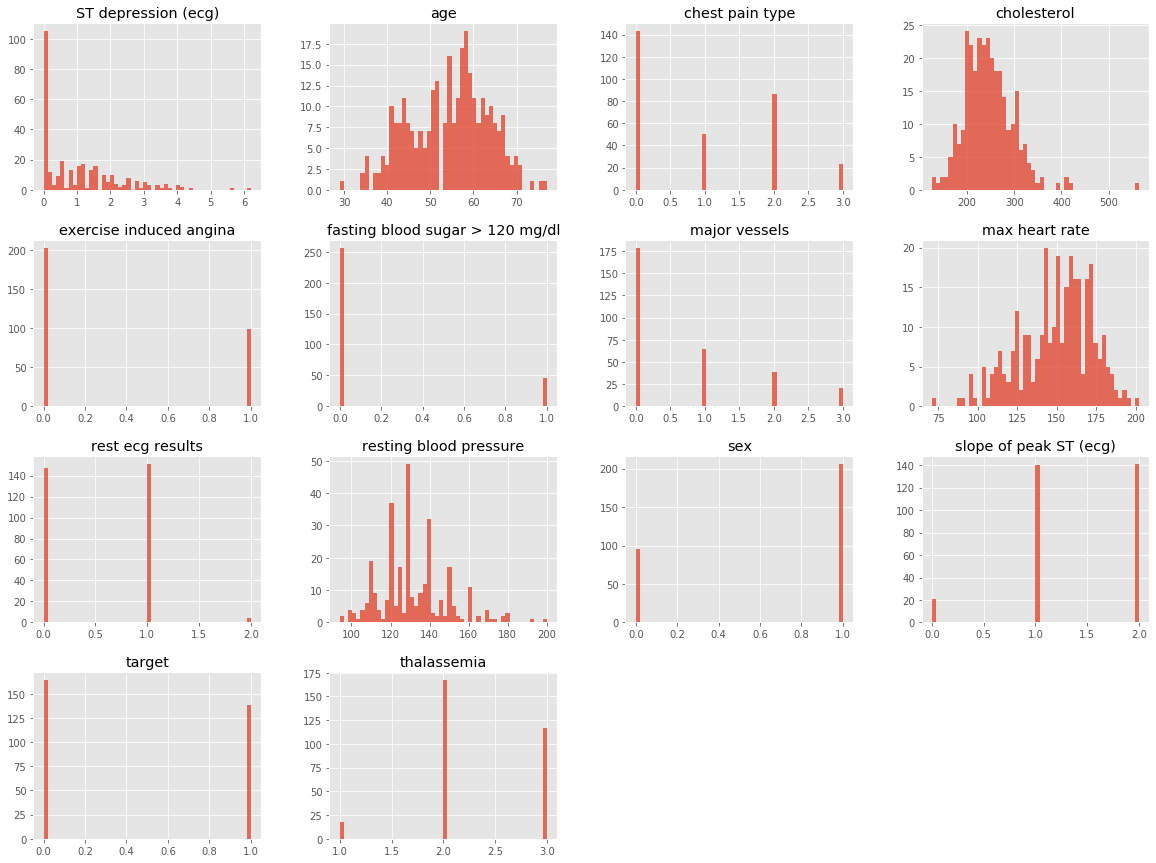

In [8]:
df.hist(bins=50, figsize = (20,15), alpha = 0.8)
plt.savefig(img_path + '\histograms')

plt.show()

This gives an overview of the distributions of all the features. We can see that the dataset is relatively balanced, i.e. there is a similar number of patients with and without heart disease.
Before we go any further with our analysis of the data, we should split it up into training and test sets.

In [9]:
#Splitting fatures into numerial and categorical features
num_features, bin_features, cat_features = separate_num_bin_cat_features(df)

In [10]:
#Reordering the columns
df = df[num_features + bin_features + cat_features + ['target']].copy()

In [11]:
X = df.drop(['target'], axis = 1).copy()
Y = df['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.2, random_state = random_state, 
                                                    stratify = Y) 


Now let's visualise the data to get a feel for what's going on.

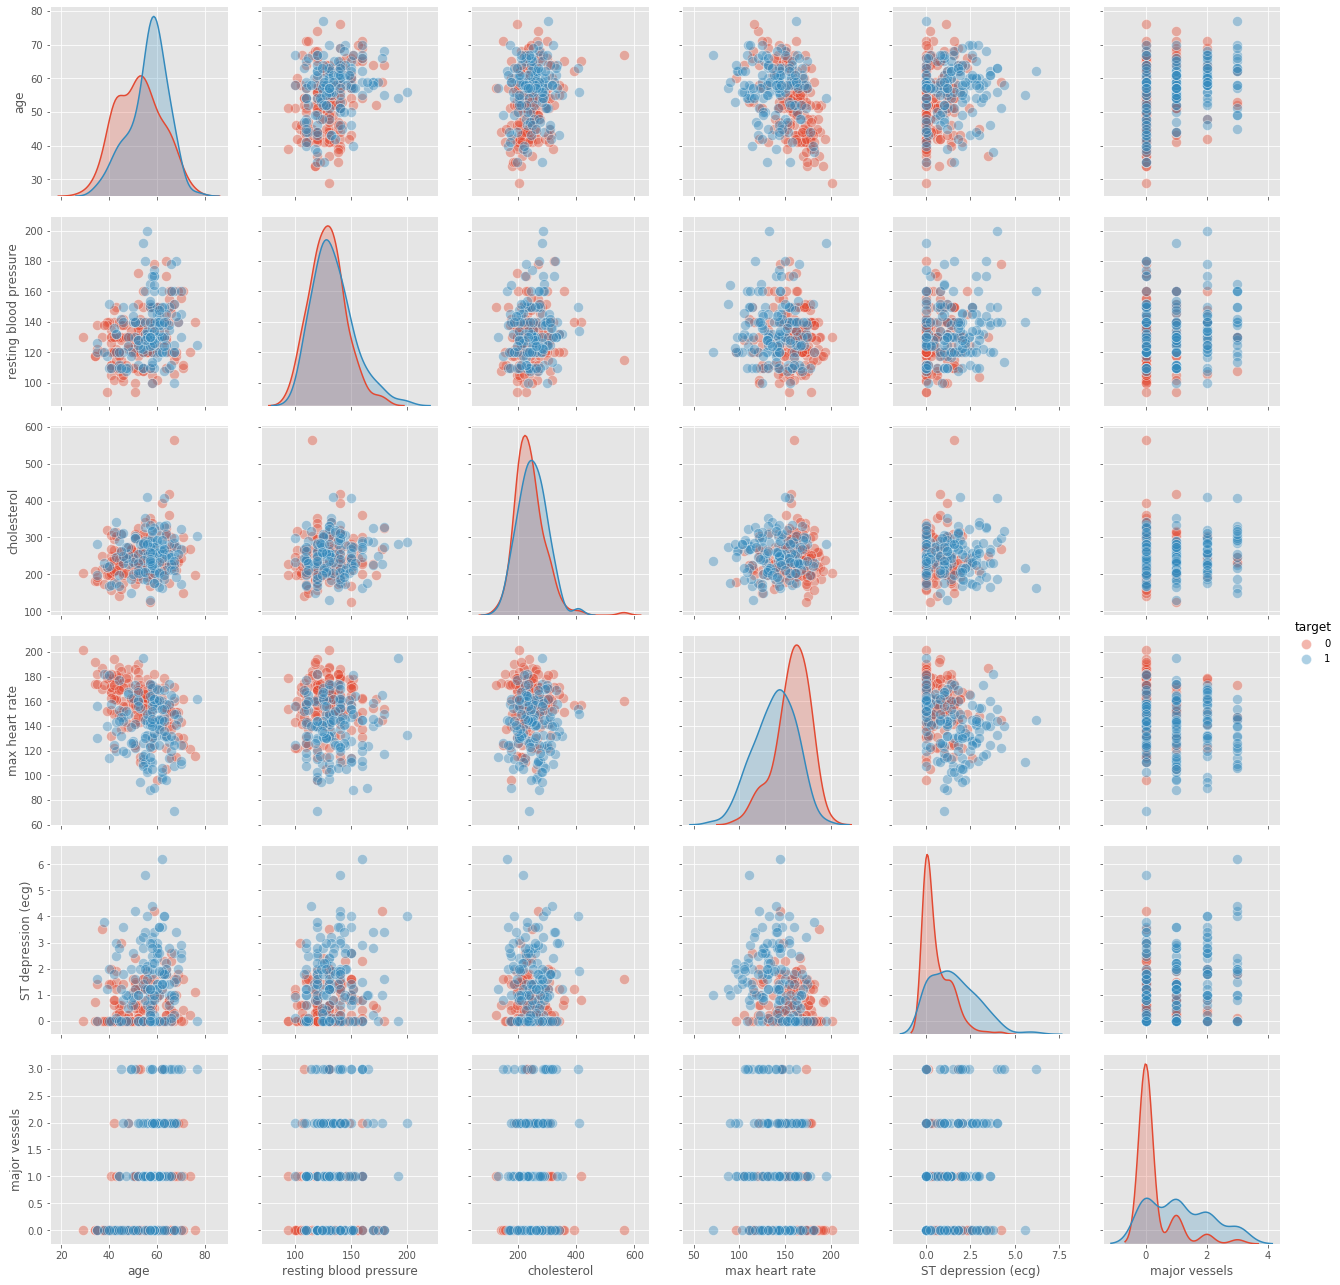

In [12]:
im = sns.pairplot(df, hue = 'target', vars = num_features, diag_kind = 'kde',
            kind = 'scatter', markers = 'o', size = 3, plot_kws = {'alpha': 0.4, 's': 100})
plt.savefig(img_path + '\scatter_plot.png')
plt.show()

Visually, it appears that ST depression, max heart rate and the number of major vessels are good predictors of the presence of heart disease. Next we'll take a look at the correlations in the data.


In [13]:
X_train_target = X_train.copy()
X_train_target['target'] = y_train
corr_matrix = X_train_target.corr()
corr_matrix['target']

age                                0.218273
resting blood pressure             0.117249
cholesterol                        0.116884
max heart rate                    -0.439663
ST depression (ecg)                0.453126
major vessels                      0.507396
sex                                0.310060
exercise induced angina            0.444046
fasting blood sugar > 120 mg/dl    0.048806
chest pain type                   -0.461978
rest ecg results                  -0.139309
slope of peak ST (ecg)            -0.350461
thalassemia                        0.321911
target                             1.000000
Name: target, dtype: float64

So the correlation coefficients back up the evidence from the above visualisation. They also suggest that chest pain type and the presence of exercise induced angina could be good predictors of heart disease. However note that chest pain type is highly negatively correlated with heart disease. This in fact suggests that chest pain type = 'asymptomatic' does not mean a lack of chest pain, and it is unclear what exactly it does mean. 

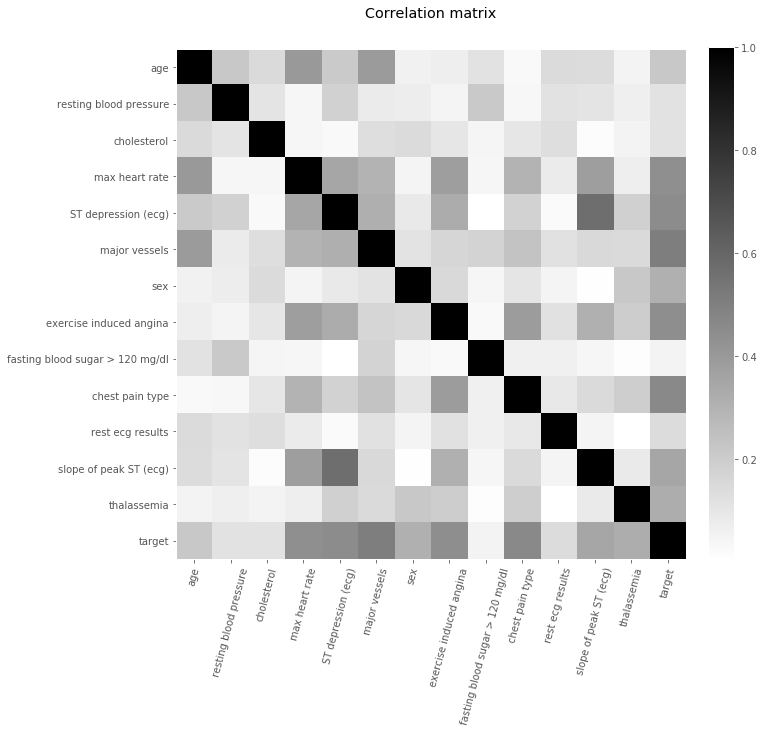

In [14]:
X_train_target = X_train.copy()
X_train_target['target'] = y_train
corr_matrix = X_train_target.corr()
corr_matrix['target']

plot_corr_matrix(corr_matrix.abs())
plt.savefig(img_path + 'corr_matrix')
plt.show()

We see that a number of the features are highly correlated, which is something we'll have to keep in mind.


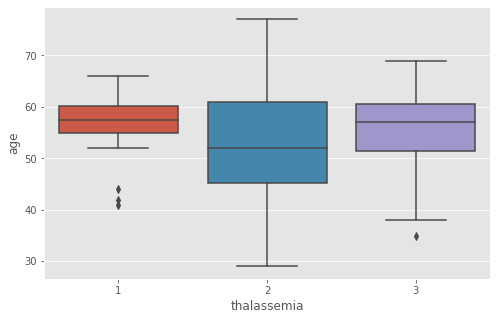

In [15]:
fig, ax = plt.subplots(figsize = (8,5))

sns.boxplot(x = 'thalassemia',y = 'age', data = X_train_target, ax = ax)
plt.savefig(img_path + r'\boxplot_thalassemia_age.png')
plt.show()

This boxplot indicates that there is no real relationship thalassemia and age. This is just a bit of a sanity check for the data since thalassemia is a genetic condition, and so shouldn't change with age.

# Preparing the data

In [16]:
def rename_cat_values(df):
    df['chest pain type'].replace([0,1,2,3],['asymptomatic cp','atypical angina cp','non-anginal cp','typical angina cp'],inplace = True)
    df['rest ecg results'].replace([0,1,2],['left ventricular hypertrophy (ecg)', 'normal ecg', 'abnormal ecg'],inplace = True)
    df['slope of peak ST (ecg)'].replace([0,1,2],['downsloping','flat','upsloping'],inplace = True)
    df['thalassemia'].replace([1,2,3], ['fixed thal','no thal','reversable thal'], inplace = True)
 

In [17]:
#We rename the values of the categorical features to improve interpretability later on.
rename_cat_values(X_train)
rename_cat_values(X_test)
X_train.tail(3)

,age,resting blood pressure,cholesterol,max heart rate,ST depression (ecg),major vessels,sex,exercise induced angina,fasting blood sugar > 120 mg/dl,chest pain type,rest ecg results,slope of peak ST (ecg),thalassemia
12,49,130,266,171,0.6,0,1,0,0,atypical angina cp,normal ecg,upsloping,no thal
180,55,132,353,132,1.2,1,1,1,0,asymptomatic cp,normal ecg,flat,reversable thal
277,57,124,261,141,0.3,0,1,0,0,atypical angina cp,normal ecg,upsloping,reversable thal


We have a pretty even spit of numerical and categorical data. We will scale the numerical data so that each of the features has mean 0 and standard deviation 1. The categorical data will be one hot encoded, and the binary data will be left alone. This should work fine for all the data except major vessels, where the order of the labels matter. So we'll treat that as numerical data. Also note that for a categorical variable with $n$ labels, we in general need only keep $n-1$ of the corresponding dummy variables, but some models prefer to keep all the variables. For example consider the case of a random forest where each node of every tree considers one feature at a time. Then if we feed this model encoded data where we drop the first dummy variable, we could have variables for 'reversable thalassemia', and 'fixed thalassemia', but none for 'no thalassemia'. Such a random forest has no way of comparing the cases of someone having thalassemia and not having thalassemia. Keeping all the dummy variables of course has the disadvantage of increasing the dimesion of our feature space and thus increasing computation time. Another advantage of keeping all the dummy variables is that we get a full explanation of the importance of each feature when we do our analysis.  


In [18]:
X_cat = X_train[cat_features].copy()
one_hot_encoder = OneHotEncoder(categories = 'auto', drop = None)
X_cat_encoded = one_hot_encoder.fit_transform(X_cat)
cat_features_encoded = one_hot_encoder.categories_

In [19]:
encoded_features = num_features + bin_features + [cat_features_encoded[i][j] for i in range(len(cat_features_encoded)) for
                                   j in range(len(cat_features_encoded[i]))]


In [20]:
cat_pipeline = Pipeline([
                ('one_hot', OneHotEncoder(categories = cat_features_encoded, drop = None))
])

num_pipeline = Pipeline([
                ('standardise', StandardScaler())
])

In [21]:
prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('bin', FunctionTransformer(), bin_features),
    ('cat', cat_pipeline, cat_features)
])

In [22]:
X_train_prepped = prep_pipeline.fit_transform(X_train)
X_test_prepped = prep_pipeline.transform(X_test)

In [23]:
#It will later become useful to have the training set where the numerical
#features are unscaled, but the categorical features are one-hot encoded
only_cat_pipeline = ColumnTransformer([
    ('num', FunctionTransformer(), num_features),
    ('bin', FunctionTransformer(), bin_features),
    ('cat', cat_pipeline, cat_features)
])
X_train = only_cat_pipeline.fit_transform(X_train)

In [24]:
filename = r'datasets\all_data_prepped.pkl'

In [25]:
with open(filename, 'wb') as f:
    pickle.dump((X_train, X_train_prepped, y_train,X_test, X_test_prepped, y_test,encoded_features), f)

In [26]:
X_train,X_train_prepped, y_train,X_test, X_test_prepped, y_test, encoded_features = pickle.load(open(filename, 'rb'))


## Training the models

Here we will train a random forest and logistic regression model.

In [27]:
#Perform a grid search to find the best parameters
random_forest = optimise_random_forest_params(X_train_prepped, y_train, scoring = 'accuracy',
                                                cv = 5, n_estimators = [100])
log_reg = optimise_log_reg_params(X_train_prepped, y_train, scoring = 'accuracy', cv = 5)

Best paramaters: {'max_depth': None, 'max_features': 4, 'min_samples_leaf': 7, 'n_estimators': 100}
Best paramaters: {'C': 0.5441832157152073, 'solver': 'lbfgs'}


In [28]:
print('Random Forest')
scoring = {'Accuracy': 'accuracy'}
#Returns performance measures of a classifier on the training set and via cross validation.
profile_clf(X_train_prepped, y_train, random_forest, scoring = scoring, cv = 5)

Random Forest
accuracy on the training set : 0.9004149377593361
Accuracy  calculated via 5-fold cross-validation:0.851(+/-0.107)


In [29]:
print('Logistic Regression')
profile_clf(X_train_prepped, y_train, log_reg, scoring = scoring, cv = 5)

Logistic Regression
accuracy on the training set : 0.8962655601659751
Accuracy  calculated via 5-fold cross-validation:0.872(+/-0.102)


Logistic regression is a readily interpretable model which allows us to determine the linear relationship between the features and the target. A random forest is a 'black box' model, which will require a little more work to interpret, but which will allow us to view the non-linear relationships between the features and the model predictions.

# Feature Importance

Both random forests and logistic regression have native methods of formulating the relative importance of features. We will present 3 methods for determining feature importance: 

    - The native methods available for random forests and logistic regression.
    - The permutation importance.
    - The Shapley values. In the case of the random forest, we can use TreeSHAP, a fast algorithm which gives exact shapley values.
    
The first two are global importance measures, i.e they answer the question 'On average, how important is feature $i$ for making a prediction'. The third is a local evaluation of feature importance, i.e. it answers the question 'How much influence did feature $i$ have when we made a prediction based on the input vector $x$?'. However as we will see, we can combine the Shapley values over all the data points to get a global measure of importance.

## Native methods

Decision trees come with a method for measuring the importance of a feature which works by adding up the total decrease in the gini coefficient from nodes that depend on that feature. For a random forest, we can average this value across all trees to get an estimate of festure importance. This is called the mean decrease in gini.

For logistic regression, the importances of a feature is just given by the absolute value of its weight. Note that this is only true since we have standardised the variables. Of course the weights themselves have a straightforward interpretation in terms of how the associated feature affects the predicted outcome. In particular, increasing feature $i$ by 1 (i.e. 1 standard deviation) multiplies the odds by $exp(w_i)$, where $w_i$ is the corresponding weight. For binary variables, changing from 0 to 1 has the same effect. Recall that the odds are given by $P(y =1)/P(y = 0)$, where $y$ is the target variable.

In [30]:
print('Random Forest:')
display(eli5.show_weights(random_forest, feature_names = encoded_features))
print('Logistic Regression:')
display(eli5.show_weights(log_reg, feature_names = encoded_features))

Random Forest:


Weight,Feature
0.1473 ± 0.3705,asymptomatic cp
0.1453 ± 0.3091,major vessels
0.1367 ± 0.3568,no thal
0.1183 ± 0.2842,ST depression (ecg)
0.0903 ± 0.2422,max heart rate
0.0794 ± 0.2873,reversable thal
0.0658 ± 0.2374,exercise induced angina
0.0379 ± 0.1300,sex
0.0356 ± 0.0964,cholesterol
0.0340 ± 0.1774,upsloping


Logistic Regression:


Weight?,Feature
+1.148,sex
+1.082,major vessels
+0.999,asymptomatic cp
+0.664,reversable thal
+0.562,ST depression (ecg)
+0.497,exercise induced angina
+0.293,cholesterol
+0.232,resting blood pressure
+0.232,flat
+0.143,left ventricular hypertrophy (ecg)


It is useful to take a moment to consider the drawbacks of using either of these as 'the' ordered list of feature importances. One thing that both methods have in common is that they examine which features play the biggest role in fitting to the training set, not which features are most useful for generalisation. If we want to know which risk factors are the most impactful on one's chance of developing heart disease, it is really this second kind of feature importance that we want. There are other drawbacks that are specific to each model:

1. Random forest:
    
    * Mean decrease in gini tends to overestimate the importance of continuous and high cardinality categorical data.
    * It also underestimates the importance of highly correlated features.
        
2. Logistic regression:
    
    * By its nature, logistic regression can only model linear relationships between the features and target, and this obviously limits its ability to demonstrate the importance of features which have a non-linear effect on the target.

    
    
The primary advantage of both is that they are trivial to compute once you have fitted the model.

## Permutation importance

Another way to measure feature importancec is via permutation importance. The idea is to randomly shuffle the values for a particular feature, and then measure by how much the performance of the model suffers.

In [31]:
log_reg.fit(X_train_prepped, y_train)
random_forest.fit(X_train_prepped, y_train)

perm_log_reg = PermutationImportance(log_reg, random_state = random_state, cv = 'prefit')
perm_random_forest = PermutationImportance(random_forest, random_state = random_state, cv = 'prefit')

perm_log_reg.fit(X_test_prepped, y_test)
perm_random_forest.fit(X_test_prepped, y_test)

print('Random Forest')
display(eli5.show_weights(perm_random_forest, feature_names = encoded_features))
print('Logistic Regression')
display(eli5.show_weights(perm_log_reg, feature_names = encoded_features))



Random Forest


Weight,Feature
0.0426 ± 0.0445,major vessels
0.0361 ± 0.0245,asymptomatic cp
0.0295 ± 0.0245,age
0.0295 ± 0.0245,cholesterol
0.0197 ± 0.0131,reversable thal
0.0164 ± 0.0000,non-anginal cp
0.0164 ± 0.0207,exercise induced angina
0.0131 ± 0.0245,no thal
0.0131 ± 0.0131,max heart rate
0.0098 ± 0.0161,left ventricular hypertrophy (ecg)


Logistic Regression


Weight,Feature
0.0557 ± 0.0533,asymptomatic cp
0.0361 ± 0.0245,max heart rate
0.0295 ± 0.0482,major vessels
0.0262 ± 0.0572,sex
0.0230 ± 0.0334,resting blood pressure
0.0230 ± 0.0792,ST depression (ecg)
0.0197 ± 0.0245,flat
0.0197 ± 0.0245,reversable thal
0.0164 ± 0.0207,upsloping
0.0131 ± 0.0131,exercise induced angina


To interpret these tables, the values describe the average change in performance of the model when we permute the corresponding feature. Negative values mean that the model accuracy actually improved when the feature values were permuted. One obvious advantage to the permutation importance is that it can be applied to any model, i.e. it is model agnostic. Also, since we computed the importance of each feature via cross validation, this represents the importance the feature plays in generalisation. It is also a very inuitive technique. 

However, it deals with correlated data poorly. This is because when we permute a particular feature, we end up with combinations of features which are very unlikely or impossible. For example, if we had a dataset consisting people heights and weights and we permuted one of these features, then the permuted data set could have instances where weight = 45kg, height = 200cm, which is obviously unrealistic. So for our data, the feature importances for ST depression, max heart rate and exercise induced angina should be taken with a grain of salt. 
We can see that the standard deviations are very high on both models. This could be due to this correlation issue. Either way, it certainly doesn't inspire a huge amount of confidence in ranking the importance of features based on the above tables.

## Shapley values

Finally, we will take a look at the Shapley values for different features. Shapley values are an idea that comes from game theory. For an input vector $x$, to compute the Shapley value of feature $i$, we  consider all the possible subset of features that don't include $i$, and see how that model prediction would change if we included $i$. We then average of all such possible subsets. There are many theoretical properties of Shaply values which make them attractive. In particular, they are the only measure of feature importance which satisfy  the following four properties simultaneously (we state these informally).
* Efficiency: The Shapley values of all features for a given prediction sum to the output of the model (i.e. the probability that target = 1).
* Symmetry: Any two features which have the same effect on the prediction are given the same Shapley value.
* Linearity: The Shapley value of a collection of features is the sum of the Shapley values of the features.
* Dummy: A feature which has no effect on the prediction has a Shapley value of 0.




We only compute the shap values for the random forest, and not logistic regression. There are a couple of reasons for this.

* TreeSHAP is a fast algorithm that comutes the exact Shapley values for the features and is unaffected by correlations in the data. For logistic regression we would have to use the KernelSHAP algorithm, which is much slower, is affected by correlations and only provides an approximation of the Shapley values.
* We will want to use Shapley values to plot dependency plots. Since logistic regression is a linear model, we already know that these plots will be linear.

In [32]:
random_forest.fit(X_train_prepped, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
explainer = shap.TreeExplainer(random_forest, X_train_prepped, model_output = 'probability')

In [34]:
data_point = X_test_prepped[0].reshape(1,-1)

In [35]:
shap.initjs()
shap_value = explainer.shap_values(data_point)
shap.force_plot(explainer.expected_value[1], shap_value[1],data_point, feature_names = encoded_features)

So how do we interpret this? First, we see that the base value is .46. This is the average probability that a patient has heart disease for this dataset according to the model. This diagram shows which features had the greatest influence in returning a probability of 0.66. The features in red are applying a 'force' to increase the probability, and this force is proportional to their Shapley values. Similarly, the features in blue decrease the probability. So for this particular patient, the fact that he has (reversable defect) thalasemmia, exercise induced angina, and his resting blood pressure are the major factors which increase the predicted probability that they have heart disease, whereas the type of chest pain and the number of major vessels they have indicates that they are less likely to have heart disease. This diagram is very good for visualising the importance of a feature for a particular datapoint. 

In [48]:
shap_values = explainer.shap_values(X_test_prepped)
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_prepped, feature_names = encoded_features)

This is an interactive combination of the force plots for each data point. It is currently sorted in such a way that points with similar shap values are clustered together. You can hover over the graph to see the most important features for a given force plot.

As we mentioned previously, the Shapley value of a feature is different for each data point. To see the overall importance of a feature, we can look at the summary plot.

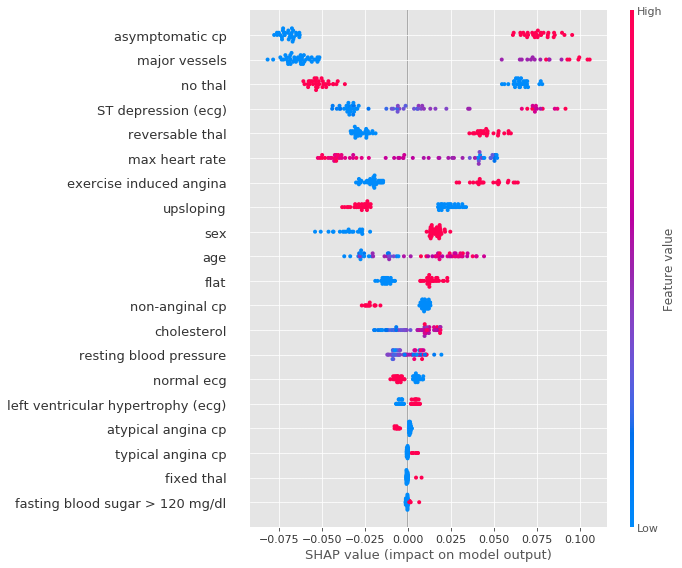

In [37]:
shap.summary_plot(shap_values[1], X_test_prepped, feature_names = encoded_features, show = False)
plt.savefig(img_path + r'\summary_plot.png')
plt.show()

This plot shows the Shapley value of each feature for each datapoint. The colour of the points indicates the value of the feature for that data point. The feautures are sorted along the y axis by the average of the absolute value of their Shapley values. If you were to choose one measure of feature importance, this would be it. Note here that positive shapley values indicate that the feature increased the predicted probability, and negative values show that the feature decreased the predicted probability. 

From this plot it is clear which of the features are most important for the random forest to make predictions on new data. We see that with the exception of resting blood pressure and age, there is a very monotonic relationship between each feature and the prediction. For major vessels, it seems that the most important thing is whether or not major vessels > 0, and after that, the effect of additional major vessels is less substantial. There is definitely something strange going on with the chest pain type variable. All types of chest pain excluding asymptomatic actually reduce the chance of heart disease. A likely cause for this is that all the patients in this data set experience some type of chest pain, and that three of those are relatively less indicative of heart disease. If this data set included many people with no chest pain at all, then we would expect all forms of chest pain to increase the chances of heart disease. This again raises the question of what it means when chest pain type = 'asymptomatic cp'. Initially it seems that it means a lack of chest pain, but given this plot that seems a bit absurd.

One unfortunate thing about this data set is that there are no features which are directly related to a person's lifestyle. It would be interesting to know, for example, in what manner a person who is overweight, a smoker, and drinks regularly, should prioritise addressing these issues(assuming that confronting all three simultaneously would be too difficult). As it stands, none of the features presented here are directly the result of lifestyle decsions, although of course things like max heart rate are likely to be associated with level of exercise.

# Relationship between features and prediction

So far we have only looked at the monotonic relationship between the features and the model predicion. To get a better insight into the true nature of these relationships, we will use partial dependence plots (PDP), individual conditional expectation (ICE) plots and dependence plots based on Shapley values. We will explain what each of these are as we come to them. We will look at these plots for the most important features as per the SHAP summary plot. Let's start by looking at PDP plots.

In [38]:
#The pdpbox module only accepts pandas dataframes as input
X_train_prepped = pd.DataFrame(X_train_prepped, columns = encoded_features)
X_test_prepped = pd.DataFrame(X_test_prepped, columns = encoded_features)
X_train = pd.DataFrame(X_train, columns = encoded_features)


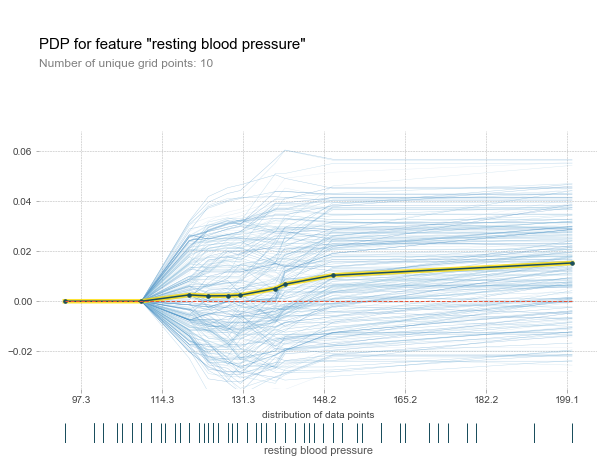

In [39]:
plot_1d_pdp(random_forest, X_train_prepped, y_train,X_train, feature = 'resting blood pressure',model_features = encoded_features,
            plot_pts_dist = True, plot_lines = True, figsize = (10,8))
plt.savefig(img_path + r'\pdp_resting_blood_pressure.png')
plt.show()

So what exactly are we looking at here? This plot shows the effect of resting blood pressure on the prediciton of the model. How this works is that for a given data point, we look at how the model prediciton changes when we permute the value of resting blood pressure. Each of the light blue lines represents a single data point, and these are the ICE plots. The thick line in the middle is the average of the ICE plots, and this is the PDP. In particular, on average having very high blood pressure only increases your probability of contracting heart disease by about 2%. In these plot we can observe the non-monotonic reltaionship between resting blood pressure and the predicted probability which was visible in the summary SHAP plot.

Since these plots are generated by permuting feature values, they suffers from the same limitations with regards to correlated features as permutation importance.

In [40]:
important_features = ['no thal','asymptomatic cp', 'reversable thal', 'exercise induced angina', 'major vessels', 'age']

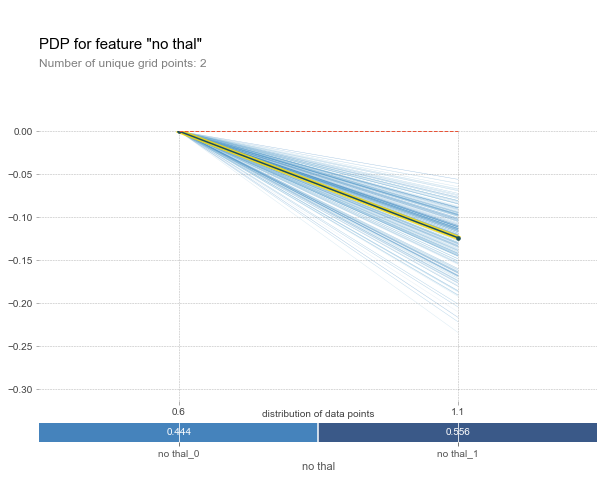

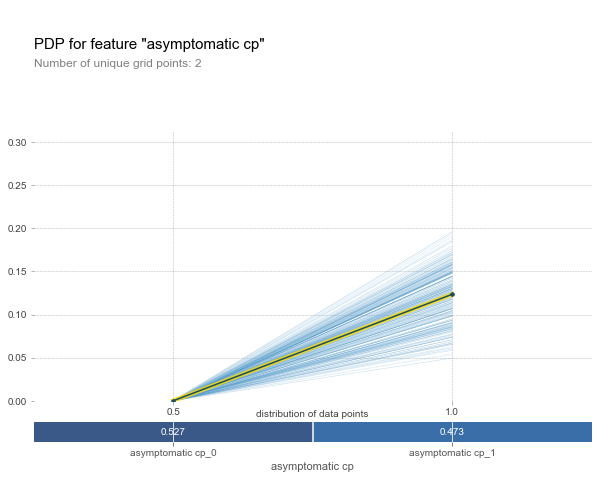

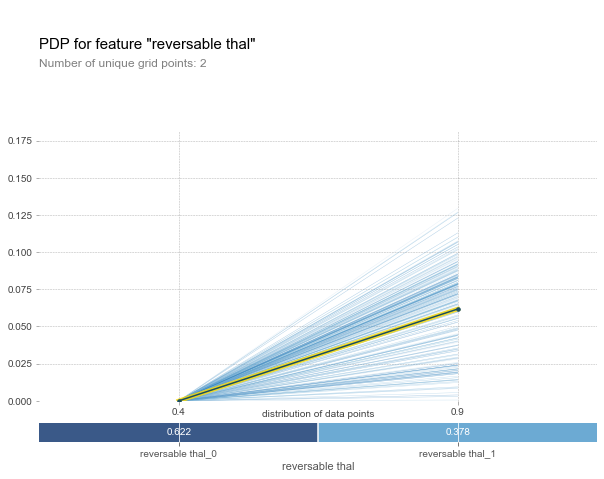

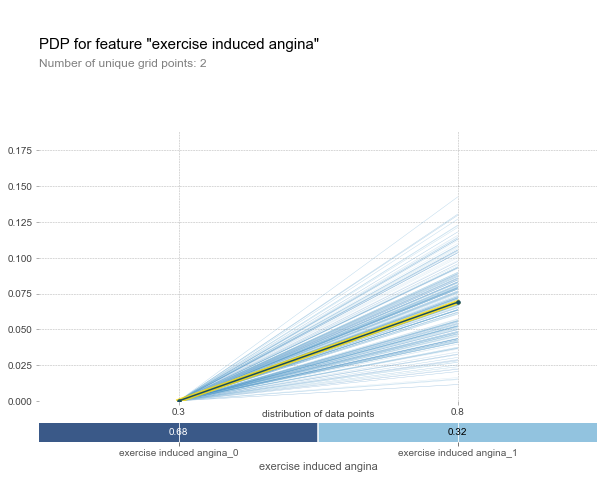

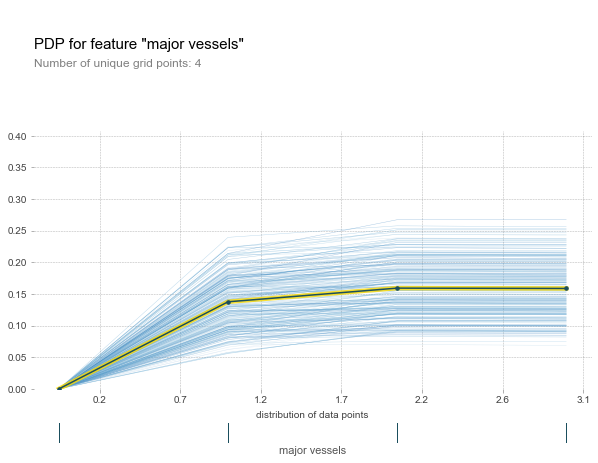

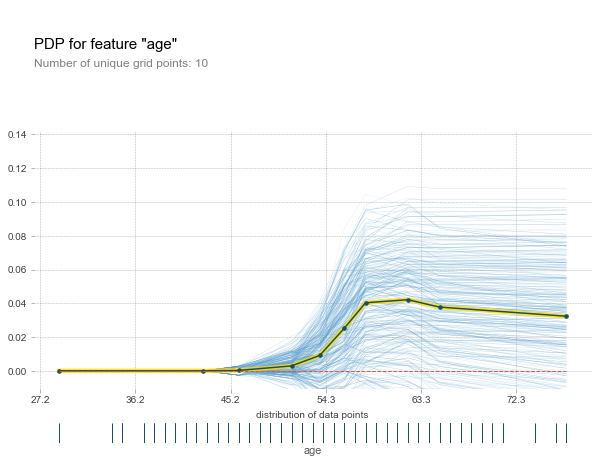

In [41]:
for feature in important_features:
    plot_1d_pdp(random_forest, X_train_prepped, y_train,X_train, model_features = encoded_features,
        feature = feature, plot_pts_dist = True, plot_lines = True, figsize = (10,8))
    plt.savefig(img_path + f'\pdp_{feature}.png')
    plt.show()

These are the plots for the five most important features, and age. We have included age because it is a feature that we would expedect to be important, and it is more easily relatable for a non-medical professional than many of the other features.
One thing to note is that for most of the features, the ICE plotd don't vary too much. However, for age we notice quite a bit of variability from patient to patient. The other notable property of the age PDP is that it is not linear. In fact, as people reach their 60's, heart disease rate plateaus. This could be because of several things:
* Survivors bias: It may be the case that if you are someone who is medically predisposed to heart disease (e.g. because of an underlying heart condition), you are less likely to live as long. 
* It may also be because factors which improve a person's longevity will necessarily reduce their chance of contracing heart disease. 
* Finally, it may be do to with the issue PDPs have with correlation. From the correlation matrix, we can see that age has a fair degree of correlation with max heart rate; young people tend to have a higher heart rate. It could be the case then, that the data for a young person with a high heart rate gets permuted to look like an old person with high heart rate, and this high heart rate reduces their probability of contracting heart disease relative to what you would expect. This is a combination which does not occur naturally in the data, and so it is reasonable that the model makes unusual predictions.
* Of course, there is also the chance that this is a byproduct of not having enough data.

We can investigate whether or not correlation is the cause by looking at the SHAP dependency plot, since Shapley values are robust to correlations in the data.

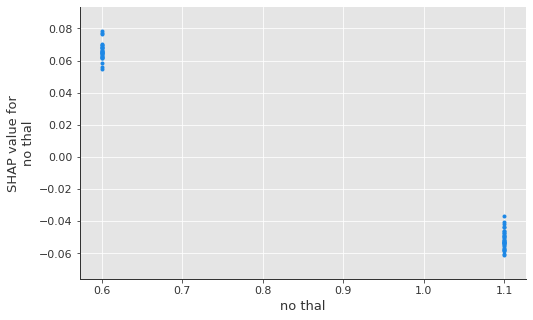

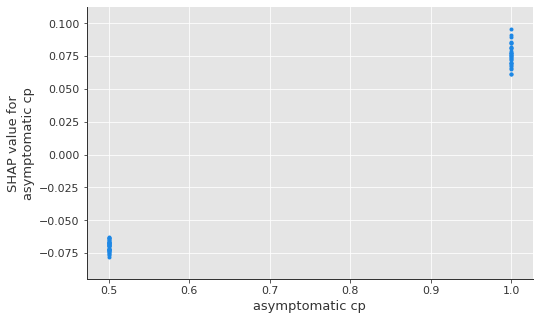

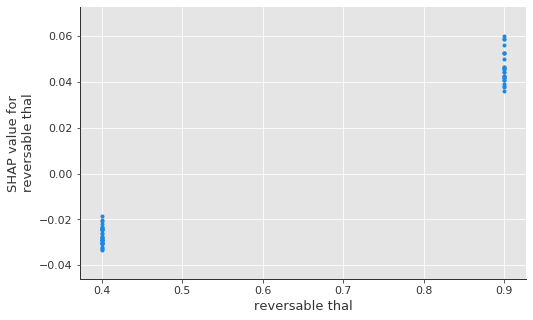

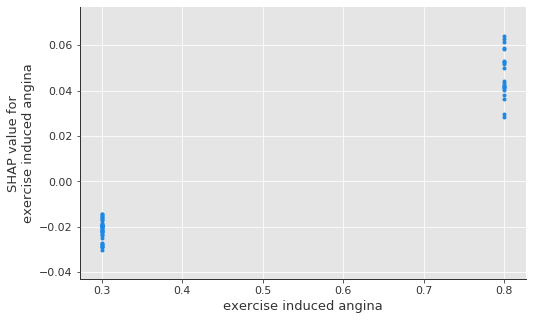

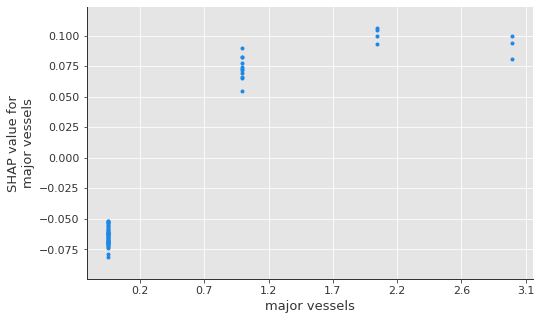

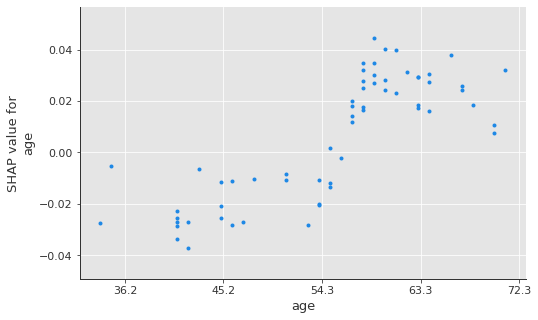

In [42]:
for feature in important_features:
    fig= plt.figure(figsize = (8,5))
    ax = plt.subplot(111)
    shap.dependence_plot(feature, shap_values[1], X_test_prepped,
                        feature_names = encoded_features,
                         interaction_index = None, ax = ax, show = False
                        )
    mean = X_train[feature].mean()
    std = X_train[feature].std()
    #Unscale x values
    def unscale_ticks(x, pos):
        return ('%.1f' %(x*std + mean))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(unscale_ticks))
    plt.savefig(img_path + f'\shap_dependecy_plot_{feature}.png')
    plt.show()

This dependency plot based on Shapley values confirms the shape of the dependencies on these features. Again, if you were to go for just one type of dependency plot, this would be the one to go for. They don't come automatically with a curve, but we can fit a kernel regression model to give us a nice curve for the continuous features.

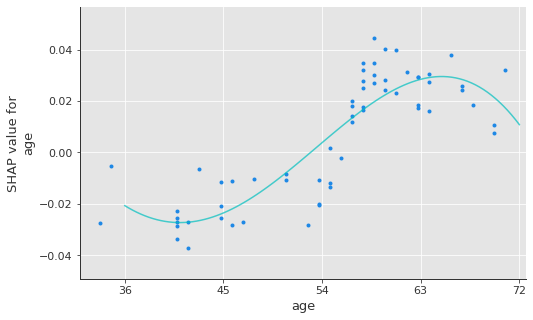

In [59]:
#Removing ouliers so the curve fits better
idx = np.argsort(X_test_prepped['age'])
X_test_temp = X_test_prepped.drop(idx[:2])
shap_values_temp_age  = np.delete(shap_values[1][:,0], idx[:2])

#Fitting polynomial regression model
kr = KernelRidge(kernel = 'sigmoid', gamma = .15, alpha = .005)
kr.fit(np.array(X_test_temp['age']).reshape(-1,1), shap_values_temp_age)

mean = X_train['age'].mean()
std = X_train['age'].std()
#Unscale x values
def unscale_ticks(x, pos):
    return ('%.0f' %(x*std + mean))

fig, ax = plt.subplots(figsize = (8,5))
shap.dependence_plot('age', shap_values[1], X_test_prepped,
                    feature_names = encoded_features,
                     interaction_index = None, ax = ax, show = False
                    )


plot_predicted_curve(kr, axes = [-2, 2, -0.05, 0.04], ax = ax, c = 'c', alpha = 0.7)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(unscale_ticks))
plt.savefig(img_path + r'\dependency_plot_with_curve_age.png')
plt.show()

## Feature interactions

Finally, we would like to look at the interactions between the features, so for example the effect that can be attributed to the combination of someone having both a high heart rate and being young. The total effect of such interactions can be visualised via PDPs. We can also use our SHAP plots. One interesting thing to look at would be how the different features interact with age. 

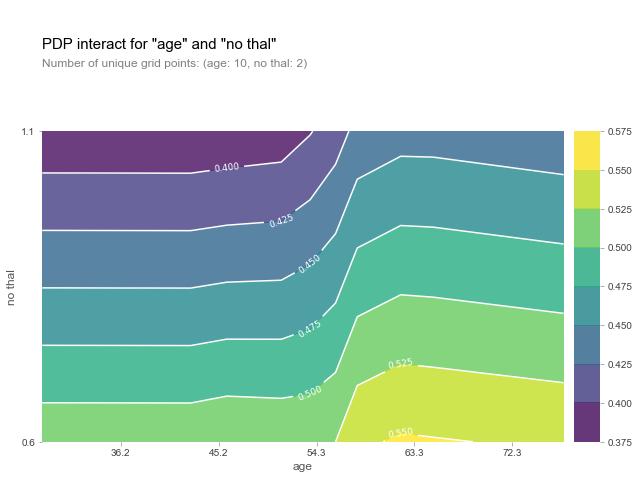

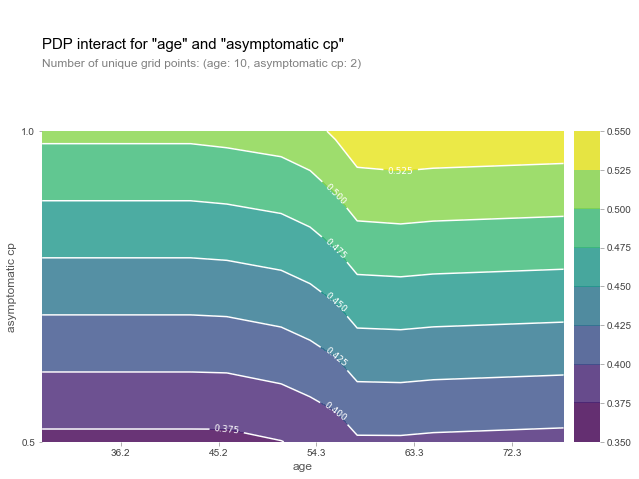

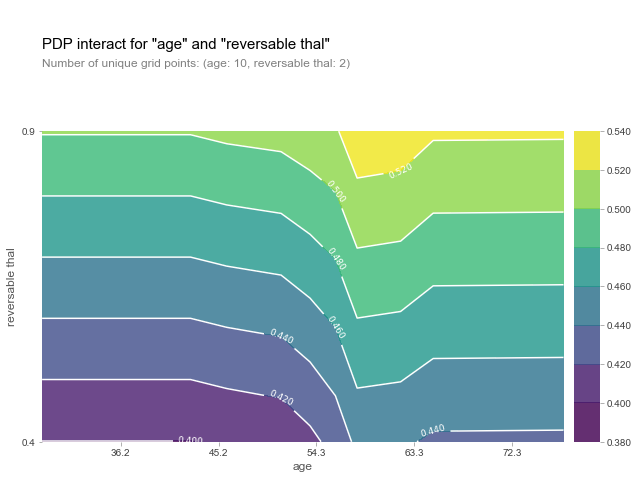

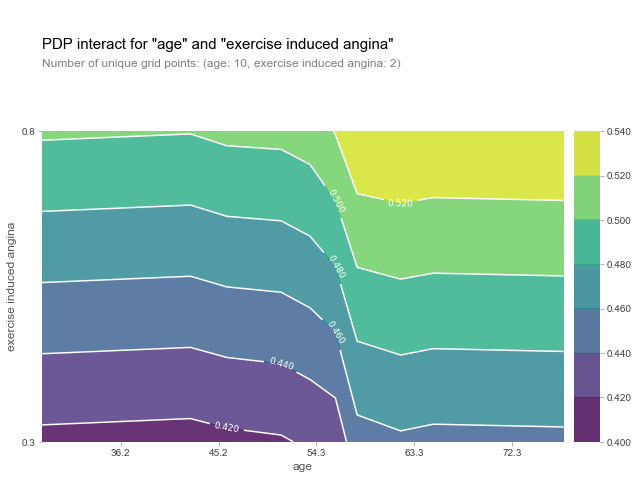

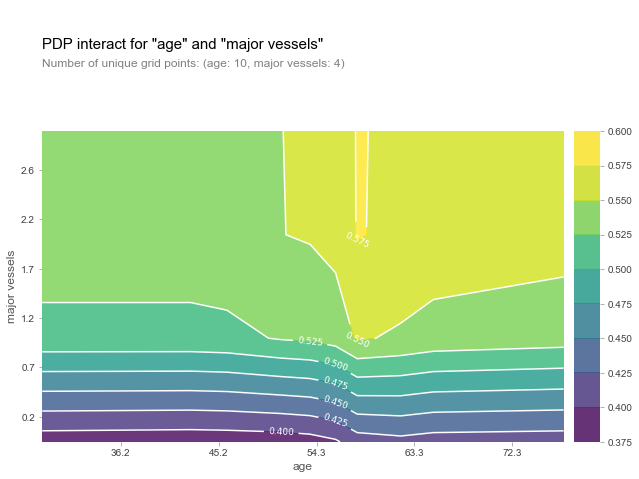

In [44]:
for feature in [feature for feature in important_features if feature != 'age']:
    plot_2d_pdp(random_forest, X_train_prepped, y_train,X_train, model_features = encoded_features,
                         features = ['age', feature], figsize = (10,8))
    plt.savefig(img_path + f'\{feature}_age_2d_pdp.png')
    
    plt.show()

These 2d dependency plots aren't so useful for the binary data, but the last two plots give a nice visualisation of the  effects of combining age with max heart rate and ST depression. The last plot in particular makes a lot of sense when we look at the scatter plot of age against max heart rate that we had before. We have no data for the regions in the top right and bottom left corners, and as we go along the diagonal from top left to bottom right the chance of having heart disease increases

And for a final visualisation, let us reconsider the SHAP dependence plots. This time we'll examine the differences in symptoms for men and women.

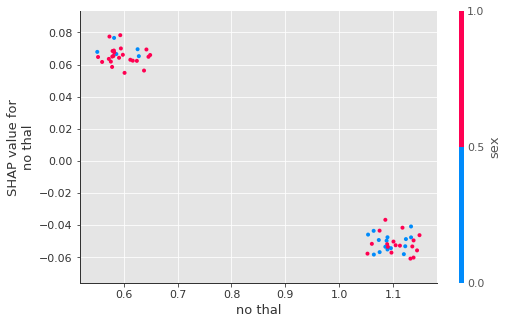

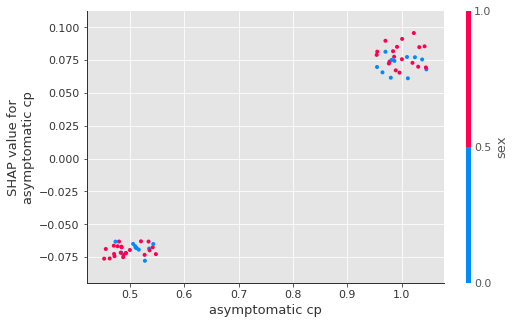

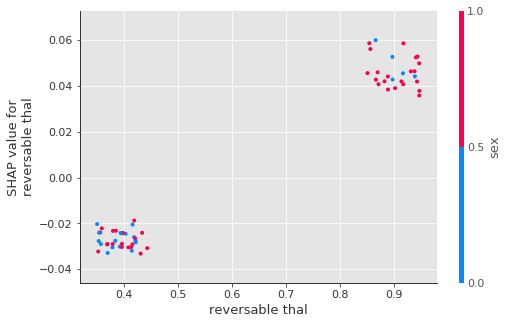

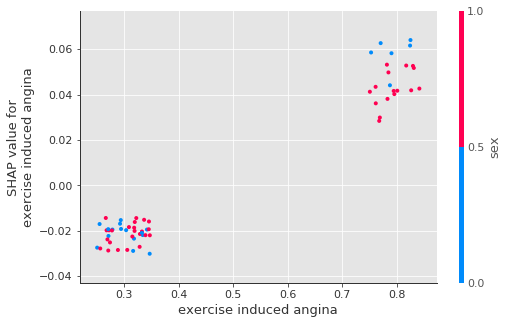

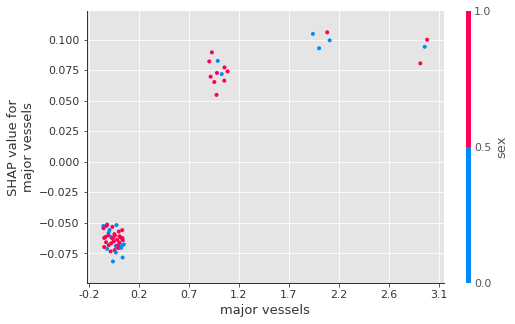

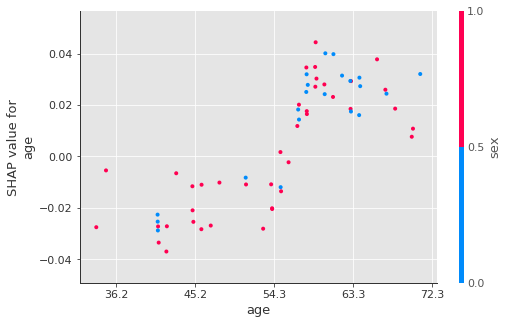

In [45]:
for feature in important_features:
    fig= plt.figure(figsize = (8,5))
    ax = plt.subplot(111)
    shap.dependence_plot(feature, shap_values[1], X_test_prepped,
                        feature_names = encoded_features,
                         interaction_index = 'sex', ax = ax, show = False, x_jitter = 0.2
                        )
    mean = X_train[feature].mean()
    std = X_train[feature].std()
    #Unscale x values
    def unscale_ticks(x, pos):
        return ('%.1f' %(x*std + mean))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(unscale_ticks))
    plt.savefig(img_path + f'\sex_{feature}_dependency_plot.png')
    plt.show()

Recall that sex = 1 indicates the person is male, so somewhat confusing the pink points correspond to men, and the blue points to women. Unsurprisingly, men are more likely to have symptoms which correlate highly with heart disease; reversabl defect thalssemia is much more common, as is having high ST depression and thalassemia. Looking at the last plot, we can see that a defect in our test data is that there are very few women below the age of 55. Lets take a look at these last plot but based on the training data. 

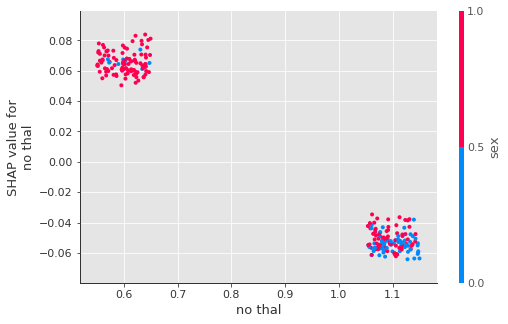

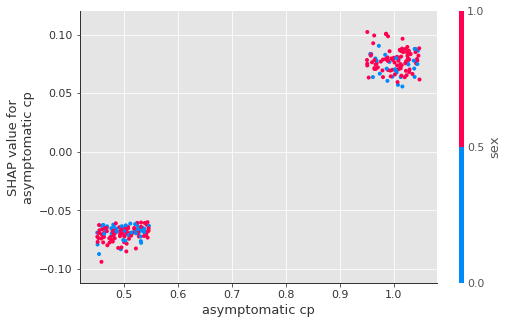

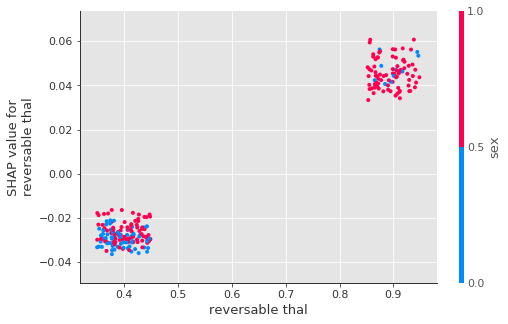

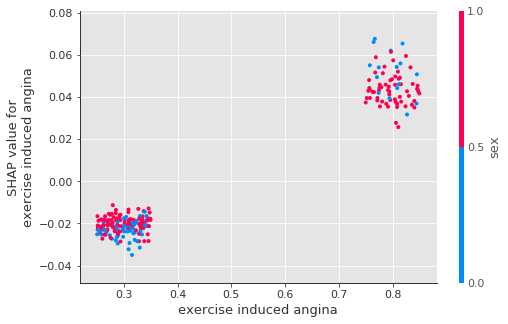

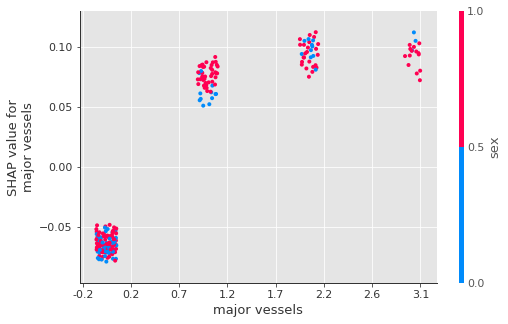

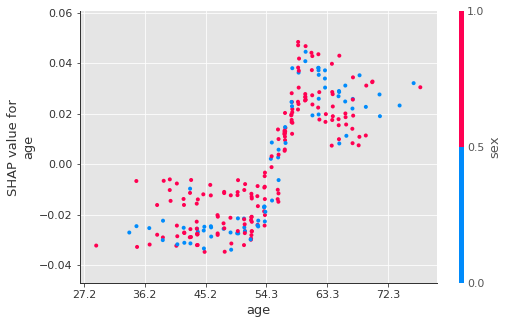

In [46]:
feature = 'age'
shap_values = explainer.shap_values(X_train_prepped)
for feature in important_features:
    fig, ax = plt.subplots(figsize = (8,5))

    shap.dependence_plot(feature, shap_values[1], X_train_prepped,
                        feature_names = encoded_features,
                         interaction_index = 'sex', ax = ax, show = False, x_jitter = 0.2
                        )
    mean = X_train[feature].mean()
    std = X_train[feature].std()
    #Unscale x values
    def unscale_ticks(x, pos):
        return ('%.1f' %(x*std + mean))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(unscale_ticks))
    plt.savefig(img_path + f'\sex_{feature}_train_dependency_plot.png')
    plt.show()

And so we see that even with the training data where we have a relatively even split of men and women at all ages, men are more likely to have many of the most important risk factors for heart disease. 